# Conditional cell diffusion processes

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr

import matplotlib.pyplot as plt
from tueplots import bundles

plt.rcParams.update(bundles.icml2024())
from flax import nnx

from neuralbridge.sdes.examples import CellSDE
from neuralbridge.sdes.base import AuxiliarySDE, GuidedProposalSDE
from neuralbridge.sdes.neural_bridge import NeuralBridge
from neuralbridge.sdes.solver import SDESolver
from neuralbridge.utils.trainer import load
from neuralbridge.utils.pcn import PCNSampler

Unconditioned cell diffusion process:
$$
\mathrm d X_t = \begin{bmatrix} \frac{X^{4}_{t,1}}{2^{-4} + X^{4}_{t,1}} + \frac{2^{-4}}{2^{-4} + X^4_{t,2}} - X_{t,1} \\ \frac{X^{4}_{t,2}}{2^{-4} + X^{4}_{t,2}} + \frac{2^{-4}}{2^{-4} + X^4_{t,1}} - X_{t,2} \end{bmatrix} \mathrm d t + \sigma \mathrm d W_t
$$
Auxiliary process
$$
\mathrm d X_t = \begin{bmatrix} 1 - X_{t,1} \\ 1 - X_{t,2} \end{bmatrix} \mathrm d t + \sigma \mathrm d W_t
$$

In [8]:
def construct_sdes(sigma, vT, T, rngs):
    sde = CellSDE(
        params={
            'sigma': sigma * jnp.eye(2)
        }
    )
    
    aux_sde = AuxiliarySDE(
        dim_x=2,
        dim_w=2,
        coeffs={
            'T': T,
            'beta': lambda t: jnp.ones(2),
            'B': lambda t: -jnp.eye(2),
            'a_tilde_0': None,
            'a_tilde_T': sigma**2 * jnp.eye(2)
            
        }
    )
    
    dt = 0.01
    n_steps = int(T / dt)
    ts = jnp.linspace(0., T, n_steps+1, endpoint=True)
    epsilon = 1e-5
    
    guided_sde = GuidedProposalSDE(
        sde, aux_sde,
        obs_params={
            'vT': vT,
            'LT': jnp.eye(2),
            'SigmaT': epsilon**2 * jnp.eye(2)
        },
        ts=ts,
        eq_type="uLM"
    )
    
    b_fn = guided_sde.b
    sigma_fn = guided_sde.sigma
    G_fn = guided_sde.G
    
    nn_config = {
        'model_name': 'MLPSmall',
        'input_dim': 2,
        'output_dim': 2,
        'hidden_dims': (32, 32, 32),
        'act_type': 'lipswish',
        'rngs': rngs
    }
    
    neural_bridge = NeuralBridge(
        b_fn, sigma_fn, G_fn, nn_config
    )
    
    return sde, aux_sde, guided_sde, neural_bridge

## Conditioned on "normal events" $[2.0, 0.1]$

In [18]:
rngs = nnx.Rngs(42)
x0 = jnp.array([0.1, -0.1])
vT = jnp.array([2.0, -0.1])
T = 4.0
sigma = 0.1

sde, aux_sde, guided_sde, neural_bridge = construct_sdes(sigma, vT, T, rngs)
load(neural_bridge, "../assets/ckpts/neural_bridge/cell/sigma_0.1_vT_2.0_-0.1")

sde_solver = SDESolver(sde, method='milstein')
nb_solver = SDESolver(neural_bridge, method='milstein')

Loaded latest model from step 5000


/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


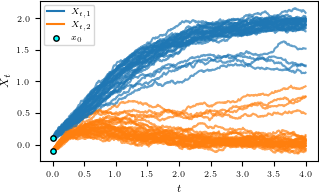

In [19]:
n_samples = 30
ts = jnp.arange(0., T+0.01, 0.01)

sde_traj = sde_solver.batch_solve(jr.PRNGKey(42), x0, ts, n_samples)

fig, ax = plt.subplots()
for i in range(n_samples):
    ax.plot(ts, sde_traj[i, :, 0], color='C0', alpha=0.7)
    ax.plot(ts, sde_traj[i, :, 1], color='C1', alpha=0.7)
ax.plot([], [], label=r"$X_{t,1}$", color='C0')
ax.plot([], [], label=r"$X_{t,2}$", color='C1')
ax.scatter([0.0, 0.0], x0, color='cyan', edgecolor='black', s=15, label=r'$x_0$', zorder=3)
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$X_{t}$")
plt.show()

In [20]:
sde_traj_many = sde_solver.batch_solve(jr.PRNGKey(42), x0, ts, 100000)
x1_mask = (sde_traj_many[:, -1, 0] >= vT[0] - 1e-2) & (sde_traj_many[:, -1, 0] <= vT[0] + 1e-2)
x2_mask = (sde_traj_many[:, -1, 1] >= vT[1] - 1e-2) & (sde_traj_many[:, -1, 1] <= vT[1] + 1e-2)
final_mask = x1_mask & x2_mask
sde_traj_filtered = sde_traj_many[final_mask]
print(f"Found {sde_traj_filtered.shape[0]} samples that satisfy the endpoint conditions out of {sde_traj_many.shape[0]}")

Found 172 samples that satisfy the endpoint conditions out of 100000


In [21]:
jnp.save("../assets/cell_normal_brutal_force.npy", sde_traj_filtered)

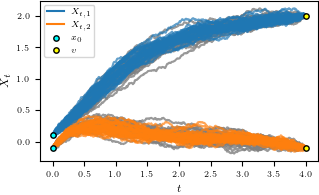

In [24]:
nb_traj_normal = nb_solver.batch_solve(jr.PRNGKey(42), x0, ts, n_samples)

fig, ax = plt.subplots()
for i in range(n_samples):
    ax.plot(ts, nb_traj_normal[i, :, 0], color='C0', alpha=0.7, zorder=2)
    ax.plot(ts, nb_traj_normal[i, :, 1], color='C1', alpha=0.7, zorder=2)
    ax.plot(ts, sde_traj_filtered[i, :, 0], color='grey', alpha=0.8, zorder=1)
    ax.plot(ts, sde_traj_filtered[i, :, 1], color='grey', alpha=0.8, zorder=1)
ax.plot([], [], label=r"$X_{t,1}$", color='C0')
ax.plot([], [], label=r"$X_{t,2}$", color='C1')

ax.scatter([0.0, 0.0], x0, color='cyan', edgecolor='black', s=15, label=r'$x_0$', zorder=3)
ax.scatter([T, T], vT, color='yellow', edgecolor='black', s=15, label=r'$v$', zorder=3)
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$X_{t}$")
fig.savefig('../assets/figures/cell/normal.pdf')
plt.show()

In [25]:
pcn_sampler = PCNSampler(guided_sde, eta=0.98)

pcn_traj_normal, lls_normal = pcn_sampler.sample(
    x0, ts, n_iters=10000, n_samples=30, n_burn_in=5000, rng_key=jr.PRNGKey(42)
)

100%|██████████| 10000/10000 [00:07<00:00, 1417.90it/s]


acceptance rate (post-burn-in): 21.38%


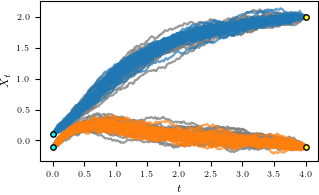

In [26]:
fig, ax = plt.subplots()
for i in range(n_samples):
    ax.plot(ts, pcn_traj_normal[i, :, 0], color='C0', alpha=0.7, zorder=2)
    ax.plot(ts, pcn_traj_normal[i, :, 1], color='C1', alpha=0.7)
    ax.plot(ts, sde_traj_filtered[i, :, 0], color='grey', alpha=0.8, zorder=1)
    ax.plot(ts, sde_traj_filtered[i, :, 1], color='grey', alpha=0.8, zorder=1)
ax.plot([], [], label=r"$X_{t,1}$", color='C0')
ax.plot([], [], label=r"$X_{t,2}$", color='C1')

ax.scatter([0.0, 0.0], x0, color='cyan', edgecolor='black', s=15, label=r'$x_0$', zorder=3)
ax.scatter([T, T], vT, color='yellow', edgecolor='black', s=15, label=r'$v$', zorder=3)
# ax.legend()
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$X_{t}$")
fig.savefig("../assets/figures/cell/pcn_normal.pdf")
plt.show()

In [27]:
import os
from flax.training import checkpoints
from neuralbridge.adjoint_forward.models.score_mlp import ScoreMLP
from neuralbridge.adjoint_forward.sdes import sde_cell_model, sde_utils
from neuralbridge.adjoint_forward.training import train_utils

network = ScoreMLP(
    output_dim=2,
    time_embedding_dim=32,
    init_embedding_dim=16,
    activation='leaky_relu',
    encoder_layer_dims=[16],
    decoder_layer_dims=[128, 128]
)
ckpt = checkpoints.restore_checkpoint(
    ckpt_dir=os.path.abspath("../assets/ckpts/adjoint/cell_model_normal_0.1sigma"),
    target=None,
    step=0,
    prefix="checkpoint_"
)
params = ckpt["params"]
batch_stats = ckpt["batch_stats"]
trained_score = train_utils.trained_score(network, params, batch_stats)

cell_sde = sde_cell_model.cell_model(
    T=4.0, 
    N=400, 
    alpha=0.0625, 
    sigma=0.1
)
n_samples = 30
rng_keys = jax.random.split(jax.random.PRNGKey(42), n_samples)
adjoint_traj_normal = jax.vmap(
    sde_utils.conditioned,
    in_axes=(0, None, None, None)
)(rng_keys, x0, cell_sde, trained_score)
adjoint_traj_normal = jnp.concatenate([jnp.repeat(x0[None, None, :], n_samples, axis=0), adjoint_traj_normal], axis=1)

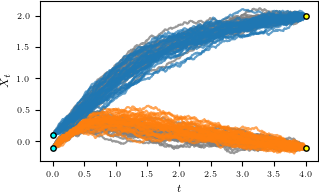

In [28]:
fig, ax = plt.subplots()
ts = jnp.linspace(0., 4., 400+1)
for i in range(n_samples):
    ax.plot(ts, adjoint_traj_normal[i, :, 0], color='C0', alpha=0.7, zorder=2)
    ax.plot(ts, adjoint_traj_normal[i, :, 1], color='C1', alpha=0.7)
    ax.plot(ts, sde_traj_filtered[i, :, 0], color='grey', alpha=0.8, zorder=1)
    ax.plot(ts, sde_traj_filtered[i, :, 1], color='grey', alpha=0.8, zorder=1)
ax.plot([], [], label=r"$X_{t,1}$", color='C0')
ax.plot([], [], label=r"$X_{t,2}$", color='C1')

ax.scatter([0.0, 0.0], x0, color='cyan', edgecolor='black', s=15, label=r'$x_0$', zorder=3)
ax.scatter([T, T], vT, color='yellow', edgecolor='black', s=15, label=r'$v$', zorder=3)
# ax.legend()
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$X_{t}$")
fig.savefig("../assets/figures/cell/adjoint_normal.pdf")
plt.show()

## Conditioned on "rare event" [1.0, -0.1]

In [58]:
rngs = nnx.Rngs(42)
x0 = jnp.array([0.1, -0.1])
vT = jnp.array([1.0, -0.1])
T = 4.0
sigma = 0.1

*_, guided_sde, neural_bridge = construct_sdes(sigma, vT, T, rngs)
load(neural_bridge, "../assets/ckpts/neural_bridge/cell/sigma_0.1_vT_1.0_-0.1")

nb_solver = SDESolver(neural_bridge, method='milstein')

Loaded latest model from step 20000


/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


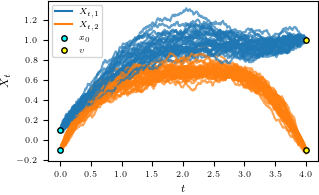

In [49]:
nb_traj_rare = nb_solver.batch_solve(jr.PRNGKey(42), x0, ts, n_samples)

fig, ax = plt.subplots()
for i in range(n_samples):
    ax.plot(ts, nb_traj_rare[i, :, 0], color='C0', alpha=0.7)
    ax.plot(ts, nb_traj_rare[i, :, 1], color='C1', alpha=0.7)
ax.plot([], [], label=r"$X_{t,1}$", color='C0')
ax.plot([], [], label=r"$X_{t,2}$", color='C1')

ax.scatter([0.0, 0.0], x0, color='cyan', edgecolor='black', s=15, label=r'$x_0$', zorder=3)
ax.scatter([T, T], vT, color='yellow', edgecolor='black', s=15, label=r'$v$', zorder=3)
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$X_{t}$")
fig.savefig('../assets/figures/cell/rare.pdf')
plt.show()

In [50]:
pcn_sampler = PCNSampler(guided_sde, eta=0.99)

pcn_traj_rare, lls_rare = pcn_sampler.sample(
    x0, ts, n_iters=20000, n_samples=30, n_burn_in=10000, rng_key=jr.PRNGKey(42)
)

100%|██████████| 20000/20000 [00:19<00:00, 1048.51it/s]

acceptance rate (post-burn-in): 22.29%


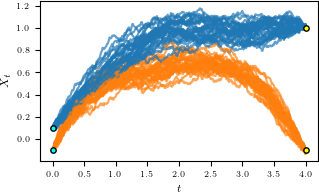

In [59]:
ts = jnp.linspace(0., 4.0, 400+1)
fig, ax = plt.subplots()
for i in range(n_samples):
    ax.plot(ts, pcn_traj_rare[i, :, 0], color='C0', alpha=0.7)
    ax.plot(ts, pcn_traj_rare[i, :, 1], color='C1', alpha=0.7)
ax.plot([], [], label=r"$X_{t,1}$", color='C0')
ax.plot([], [], label=r"$X_{t,2}$", color='C1')

ax.scatter([0.0, 0.0], x0, color='cyan', edgecolor='black', s=15, label=r'$x_0$', zorder=3)
ax.scatter([T, T], vT, color='yellow', edgecolor='black', s=15, label=r'$v$', zorder=3)
# ax.legend()
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$X_{t}$")
fig.savefig("../assets/figures/cell/pcn_rare.pdf")
plt.show()

In [30]:
network = ScoreMLP(
    output_dim=2,
    time_embedding_dim=32,
    init_embedding_dim=16,
    activation='leaky_relu',
    encoder_layer_dims=[16],
    decoder_layer_dims=[128, 128]
)
ckpt = checkpoints.restore_checkpoint(
    ckpt_dir=os.path.abspath("../assets/ckpts/adjoint/cell_model_rare_0.1sigma"),
    target=None,
    step=0,
    prefix="checkpoint_"
)
params = ckpt["params"]
batch_stats = ckpt["batch_stats"]
trained_score = train_utils.trained_score(network, params, batch_stats)

cell_sde = sde_cell_model.cell_model(
    T=4.0, 
    N=400, 
    alpha=0.0625, 
    sigma=0.1
)
n_samples = 30
rng_keys = jax.random.split(jax.random.PRNGKey(42), n_samples)
adjoint_traj_rare = jax.vmap(
    sde_utils.conditioned,
    in_axes=(0, None, None, None)
)(rng_keys, x0, cell_sde, trained_score)
adjoint_traj_rare = jnp.concatenate([jnp.repeat(x0[None, None, :], n_samples, axis=0), adjoint_traj_rare], axis=1)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


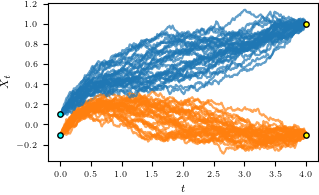

In [32]:
fig, ax = plt.subplots()
ts = jnp.linspace(0., 4., 400+1)
for i in range(n_samples):
    ax.plot(ts, adjoint_traj_rare[i, :, 0], color='C0', alpha=0.7)
    ax.plot(ts, adjoint_traj_rare[i, :, 1], color='C1', alpha=0.7)
ax.plot([], [], label=r"$X_{t,1}$", color='C0')
ax.plot([], [], label=r"$X_{t,2}$", color='C1')

ax.scatter([0.0, 0.0], x0, color='cyan', edgecolor='black', s=15, label=r'$x_0$', zorder=3)
ax.scatter([T, T], [1.0, -0.1], color='yellow', edgecolor='black', s=15, label=r'$v$', zorder=3)
# ax.legend()
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$X_{t}$")
fig.savefig("../assets/figures/cell/adjoint_rare.pdf")
plt.show()

## Conditioned on "multi-modality" event [-1.0, -1.0]

In [38]:
rngs = nnx.Rngs(42)
x0 = jnp.array([-1.0, -1.0])
vT = jnp.array([-1.0, -1.0])
T = 5.0
ts = jnp.linspace(0., T, 500+1, endpoint=True)
sigma = 0.1

sde, _, guided_sde, neural_bridge = construct_sdes(sigma, vT, T, rngs)
load(neural_bridge, "../assets/ckpts/neural_bridge/cell/sigma_0.1_vT_-1.0_-1.0")

nb_solver = SDESolver(neural_bridge, method='milstein')

Loaded latest model from step 10000


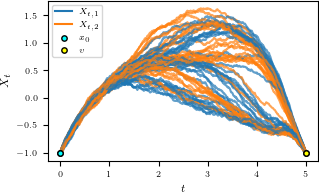

In [39]:
n_samples = 30

nb_traj = nb_solver.batch_solve(jr.PRNGKey(42), x0, ts, n_samples)

fig, ax = plt.subplots()
for i in range(n_samples):
    ax.plot(ts, nb_traj[i, :, 0], color='C0', alpha=0.7)
    ax.plot(ts, nb_traj[i, :, 1], color='C1', alpha=0.7)
ax.plot([], [], label=r"$X_{t,1}$", color='C0')
ax.plot([], [], label=r"$X_{t,2}$", color='C1')

ax.scatter([0.0, 0.0], x0, color='cyan', edgecolor='black', s=15, label=r'$x_0$', zorder=3)
ax.scatter([T, T], vT, color='yellow', edgecolor='black', s=15, label=r'$v$', zorder=3)
ax.legend()
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$X_{t}$")
fig.savefig('../assets/figures/cell/multimodal.pdf')
plt.show()

In [55]:
pcn_sampler = PCNSampler(guided_sde, eta=0.9)

pcn_traj_mm, lls_mm = pcn_sampler.sample(
    x0, ts, n_iters=50000, n_samples=30, n_burn_in=20000, rng_key=jr.PRNGKey(42)
)

100%|██████████| 50000/50000 [02:05<00:00, 399.45it/s] 

acceptance rate (post-burn-in): 26.81%


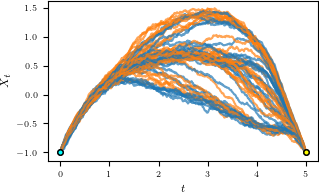

In [64]:
fig, ax = plt.subplots()
for i in range(n_samples):
    ax.plot(ts, pcn_traj_mm[i, :, 0], color='C0', alpha=0.7)
    ax.plot(ts, pcn_traj_mm[i, :, 1], color='C1', alpha=0.7)
ax.plot([], [], label=r"$X_{t,1}$", color='C0')
ax.plot([], [], label=r"$X_{t,2}$", color='C1')

ax.scatter([0.0, 0.0], x0, color='cyan', edgecolor='black', s=15, label=r'$x_0$', zorder=3)
ax.scatter([T, T], vT, color='yellow', edgecolor='black', s=15, label=r'$v$', zorder=3)
# ax.legend()
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$X_{t}$")
fig.savefig("../assets/figures/cell/pcn_multimodal.pdf")
plt.show()

In [36]:
network = ScoreMLP(
    output_dim=2,
    time_embedding_dim=32,
    init_embedding_dim=16,
    activation='leaky_relu',
    encoder_layer_dims=[16],
    decoder_layer_dims=[128, 128]
)
ckpt = checkpoints.restore_checkpoint(
    ckpt_dir=os.path.abspath("../assets/ckpts/adjoint/cell_model_mm_0.1sigma"),
    target=None,
    step=0,
    prefix="checkpoint_"
)
params = ckpt["params"]
batch_stats = ckpt["batch_stats"]
trained_score = train_utils.trained_score(network, params, batch_stats)

cell_sde = sde_cell_model.cell_model(
    T=5.0, 
    N=500, 
    alpha=0.0625, 
    sigma=0.1
)
n_samples = 30
rng_keys = jax.random.split(jax.random.PRNGKey(42), n_samples)
adjoint_traj_mm = jax.vmap(
    sde_utils.conditioned,
    in_axes=(0, None, None, None)
)(rng_keys, x0, cell_sde, trained_score)
adjoint_traj_mm = jnp.concatenate([jnp.repeat(x0[None, None, :], n_samples, axis=0), adjoint_traj_mm], axis=1)

/opt/homebrew/Caskroom/miniconda/base/envs/neuralbridge/lib/python3.10/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1251: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


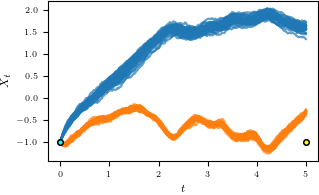

In [37]:
fig, ax = plt.subplots()
ts = jnp.linspace(0., 5., 500+1)
for i in range(n_samples):
    ax.plot(ts, adjoint_traj_mm[i, :, 0], color='C0', alpha=0.7)
    ax.plot(ts, adjoint_traj_mm[i, :, 1], color='C1', alpha=0.7)
ax.plot([], [], label=r"$X_{t,1}$", color='C0')
ax.plot([], [], label=r"$X_{t,2}$", color='C1')

ax.scatter([0.0, 0.0], [-1.0, -1.0], color='cyan', edgecolor='black', s=15, label=r'$x_0$', zorder=3)
ax.scatter([T, T], [-1.0, -1.0], color='yellow', edgecolor='black', s=15, label=r'$v$', zorder=3)
# ax.legend()
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$X_{t}$")
fig.savefig("../assets/figures/cell/adjoint_multimodal.pdf")
plt.show()

In [9]:
nb_traj = nb_solver.batch_solve(jr.PRNGKey(42), x0, ts, 10000)

In [10]:
sde_solver = SDESolver(sde, method='milstein')
sde_traj = sde_solver.batch_solve(jr.PRNGKey(42), x0, ts, 10000)

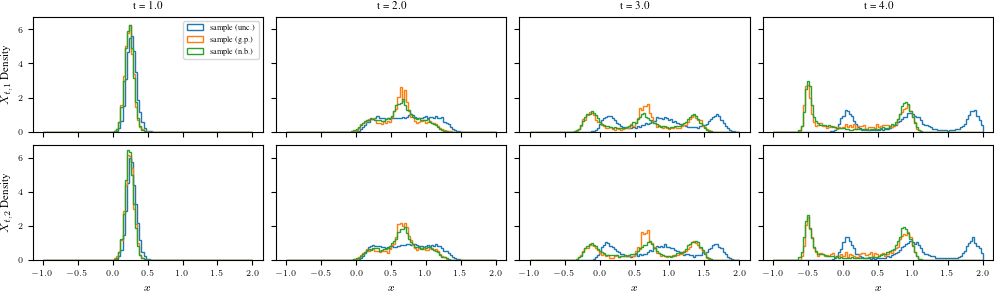

In [28]:
t_slices = [1.0, 2.0, 3.0, 4.0]
x_range = (-1.0, 2.0)

fig, axes = plt.subplots(2, 4, figsize=(10, 3), sharey=True, sharex=True)

for i, t_slice in enumerate(t_slices):
    t_idx = jnp.searchsorted(ts, t_slice)
    
    ax1 = axes[0][i]
    ax1.hist(sde_traj[:, t_idx, 0], bins=100, density=True, range=x_range, label='sample (unc.)', histtype='step', edgecolor='C0')
    ax1.hist(pcn_traj_mm[:, t_idx, 0], bins=100, density=True, range=x_range, label='sample (g.p.)', histtype='step', edgecolor='C1')
    ax1.hist(nb_traj[:, t_idx, 0], bins=100, density=True, range=x_range, label='sample (n.b.)', histtype='step', edgecolor='C2')
    
    ax1.set_title(f't = {t_slice:.1f}')
    
    ax2 = axes[1][i]
    ax2.hist(sde_traj[:, t_idx, 1], bins=100, density=True, range=x_range, label='sample (unc.)', histtype='step', edgecolor='C0')
    ax2.hist(pcn_traj_mm[:, t_idx, 1], bins=100, density=True, range=x_range, label='sample (g.p.)', histtype='step', edgecolor='C1')
    ax2.hist(nb_traj[:, t_idx, 1], bins=100, density=True, range=x_range, label='sample (n.b.)', histtype='step', edgecolor='C2')
    ax2.set_xlabel(r'$x$')
    
    if i == 0:
        ax1.legend(loc='upper right')
        ax1.set_ylabel(r'$X_{t,1}$ Density')
        ax2.set_ylabel(r'$X_{t,2}$ Density')
fig.savefig('../assets/figures/cell/multimodal_hist.pdf')

In [42]:
pcn_sampler = PCNSampler(guided_sde, eta=0.9)

pcn_traj_mm_chain1, _ = pcn_sampler.sample(
    x0, ts, n_iters=20000, n_samples=10000, n_burn_in=10000, rng_key=jr.PRNGKey(42)
)

100%|██████████| 20000/20000 [00:23<00:00, 865.69it/s] 

acceptance rate (post-burn-in): 24.08%


In [48]:
pcn_traj_mm_chain2, _ = pcn_sampler.sample(
    x0, ts, n_iters=20000, n_samples=10000, n_burn_in=10000, rng_key=jr.PRNGKey(29)
)

100%|██████████| 20000/20000 [00:22<00:00, 876.84it/s] 

acceptance rate (post-burn-in): 23.58%


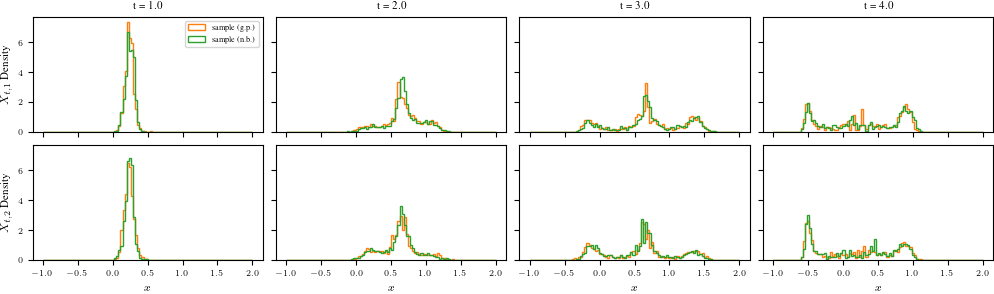

In [49]:
t_slices = [1.0, 2.0, 3.0, 4.0]
x_range = (-1.0, 2.0)

fig, axes = plt.subplots(2, 4, figsize=(10, 3), sharey=True, sharex=True)

for i, t_slice in enumerate(t_slices):
    t_idx = jnp.searchsorted(ts, t_slice)
    
    ax1 = axes[0][i]
    ax1.hist(pcn_traj_mm_chain1[:, t_idx, 0], bins=100, density=True, range=x_range, label='sample (g.p.)', histtype='step', edgecolor='C1')
    ax1.hist(pcn_traj_mm_chain2[:, t_idx, 0], bins=100, density=True, range=x_range, label='sample (n.b.)', histtype='step', edgecolor='C2')
    
    ax1.set_title(f't = {t_slice:.1f}')
    
    ax2 = axes[1][i]
    ax2.hist(pcn_traj_mm_chain1[:, t_idx, 1], bins=100, density=True, range=x_range, label='sample (g.p.)', histtype='step', edgecolor='C1')
    ax2.hist(pcn_traj_mm_chain2[:, t_idx, 1], bins=100, density=True, range=x_range, label='sample (n.b.)', histtype='step', edgecolor='C2')
    ax2.set_xlabel(r'$x$')
    
    if i == 0:
        ax1.legend(loc='upper right')
        ax1.set_ylabel(r'$X_{t,1}$ Density')
        ax2.set_ylabel(r'$X_{t,2}$ Density')
# fig.savefig('../assets/figures/cell/multimodal_hist.pdf')